In [1]:
# sklearn Models
from sklearn.linear_model import LogisticRegression

# sklearn Utils
from sklearn.base import BaseEstimator
from sklearn.base import clone
from scipy.stats import entropy
from sklearn.model_selection import train_test_split

import numpy as np
from numpy.random import default_rng
import random

np.random.seed(42)

from matplotlib.ticker import FormatStrFormatter
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


try:
    import tensorflow as tf
except ModuleNotFoundError:
    %pip install -qq tensorflow
    import tensorflow as tf

try:
    import probml_utils as pml
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    import probml_utils as pml

from probml_utils import active_learn_utils as alu

try:
    import modAL
except ModuleNotFoundError:
    %pip install -qq modAL
    import modAL


from modAL.uncertainty import uncertainty_sampling
from modAL.uncertainty import entropy_sampling
from modAL.uncertainty import margin_sampling
from modAL.disagreement import max_std_sampling

from modAL.uncertainty import classifier_entropy
from modAL.uncertainty import classifier_margin
from modAL.uncertainty import classifier_uncertainty

from modAL.models import ActiveLearner
from modAL.utils.data import modALinput

from typing import Callable
from typing import Tuple
from typing import Optional
import warnings
from typing import List

from functools import reduce
import operator

2022-07-28 12:35:00.936159: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-07-28 12:35:00.939814: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-28 12:35:00.939824: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Classification for Multiclass MNIST dataset

In [4]:
def animate_classification_mnist(
    sampling_dict_class: dict,
    plot_list: list,
    model: BaseEstimator,
    grid_row: int = 3,
    grid_col: int = 4,
    n_queries: int = 100,
    train_size: int = 750,
):
    """
    Make MNIST Probability and uncertanity plots

    Args:
    ----------
    sampling_dict_class :
        Dictionary to store data for all different uncertanity techniques

    plot_list:
        Choose the plots you want to see

    model:
        Model used

    grid_row:
        # of rows in plot

    grid_col:
        # of columns in plot

    n_queries:
        # of queries for uncertanity sampling

    train_size:
        Initial train size

    Returns:
    ----------
    None

    """
    if pml.is_latexify_enabled():
        if len(plot_list) == 3:
            pml.latexify(width_scale_factor=1, fig_height=2.5)
        else:
            pml.latexify(width_scale_factor=1, fig_height=1.5)

        fig, ax = plt.subplots(grid_row, grid_col)

        # Remove grids from all plots if latexifying

        label_fontsize = 6
        tick_fontsize = 6
        annotate_fontsize = 4
        grid_linewidth = 0.4
        title_fontsize = 6
        legend_fontsize = 4
    else:
        if len(plot_list) == 3:
            fig, ax = plt.subplots(grid_row, grid_col, figsize=(10, 10))
        else:
            fig, ax = plt.subplots(grid_row, grid_col, figsize=(10, 7))

        label_fontsize = 10
        tick_fontsize = 10
        grid_linewidth = 1
        title_fontsize = 10
        annotate_fontsize = 8
        legend_fontsize = 7

    # Get and split Data
    (train_pool_X, train_pool_y), (test_X, test_y) = tf.keras.datasets.mnist.load_data()
    X_train, X_pool, y_train, y_pool = train_test_split(
        train_pool_X,
        train_pool_y,
        train_size=train_size,
        random_state=42,
        stratify=train_pool_y,
    )

    # Reshape train and pool data
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_pool = X_pool.reshape(X_pool.shape[0], -1)

    # Fit an active learning model and query a sample based on 3 different uncertanity sampling stratergies
    for key, value in sampling_dict_class.items():
        active_model = modAL.models.ActiveLearner(
            estimator=model,
            query_strategy=value["query_strat"],
            X_training=X_train,
            y_training=y_train,
        )
        query_idx, query_sample = active_model.query(X_pool, n_instances=1)
        value["sample"] = query_sample
        value["sample_label"] = y_pool[query_idx]

    # Make a dicitionary of queried point data and target
    queried_dict = {value["sample_label"][0]: value["sample"].reshape(1, -1) for value in sampling_dict_class.values()}

    # Fit the model
    model_fit = model.fit(X_train, y_train)

    # Iterate over different sampling stratergies
    for col, (key, value) in enumerate(sampling_dict_class.items()):

        # Plot 3 graphs for each uncertanity technique
        for row, graph_type in enumerate(plot_list):

            if graph_type == "imshow":
                ax[row][col].grid(False)
                ax[row][col].imshow(value["sample"].reshape(28, 28))
                ax[row][col].set_xticks(())
                ax[row][col].set_yticks(())
                title = f"{key} sampling"

            elif graph_type == "probability":
                proba = model_fit.predict_proba(value["sample"])
                
                ax[row][col].spines['right'].set_visible(False)
                ax[row][col].spines['top'].set_visible(False)

                # Plot probability bars
                ax[row][col].bar([i for i in range(10)], proba.squeeze(), color="lightblue", zorder=3, alpha=0.6)

                # Sort Probability list to find max_proba and second_max_proba
                proba_sorted = sorted(proba.squeeze().tolist(), reverse=True)

                max_proba = proba_sorted[0]
                second_max_proba = None

                for prob in proba_sorted:
                    if prob < max_proba:
                        second_max_proba = prob
                        break

                # Annotate patches
                patches_list = ax[row][col].patches

                for bar in patches_list:
                    cx = bar.get_x() + bar.get_width() / 2
                    cy = bar.get_height() + 0.05

                    if bar.get_height() in [max_proba, second_max_proba]:
                        ax[row][col].annotate(
                            f"{bar.get_height():.4f}",
                            (cx, cy),
                            color="black",
                            weight="bold",
                            fontsize=annotate_fontsize,
                            ha="center",
                            va="center",
                            zorder=2,
                        )

                    if bar.get_height() == max_proba:
                        bar.set_color("dimgrey")
                    elif second_max_proba != None and bar.get_height() == second_max_proba:
                        bar.set_color("lightgray")

                # Set graphing options
                ax[row][col].set_xlabel("Predicted Digit", fontsize=label_fontsize)
                ax[row][col].set_xticks(np.arange(10))
                plt.setp(ax[row][col].get_xticklabels(), fontsize=tick_fontsize)
                ax[row][col].set_ylim(0, 0.6)
                plt.setp(ax[row][col].get_yticklabels(), fontsize=tick_fontsize)

                # Add y_label to only the first columns
                if col == 0:
                    ax[row][col].set_ylabel("Probability", fontsize=label_fontsize)

                # Remove ticks from columns without affecting grid lines
                if col != 0:
                    for tick in ax[row][col].yaxis.get_major_ticks():
                        tick.tick1line.set_visible(False)
                        tick.tick2line.set_visible(False)
                        tick.label1.set_visible(False)
                        tick.label2.set_visible(False)

            elif graph_type == "uncertanity":

                margin_uncert = classifier_margin(model, value["sample"])
                leastc_uncert = classifier_uncertainty(model, value["sample"])
                entropy_uncert = classifier_entropy(model, value["sample"])
                
                
                ax[row][col].bar(
                    [1, 3, 5],
                    [margin_uncert[-1], leastc_uncert[-1], entropy_uncert[-1]],
                    color=["green", "blue", "darkorange"],
                    zorder=3,
                )
                ax[row][col].spines['right'].set_visible(False)
                ax[row][col].spines['top'].set_visible(False)

                for bar in ax[row][col].patches:
                    cy = bar.get_y() + bar.get_height() + 0.10
                    cx = bar.get_x() + bar.get_width() / 2

                    ax[row][col].text(
                        cx,
                        cy,
                        f"{bar.get_height():.3f}",
                        rotation=0,
                        color="black",
                        fontsize=5 if pml.is_latexify_enabled() else 8,
                        ha="center",
                        va="center",
                        zorder=2,
                        weight="bold",
                    )

                # Graphing Options
                for tick in ax[row][col].xaxis.get_major_ticks():
                    tick.tick1line.set_visible(False)
                    tick.tick2line.set_visible(False)
                    tick.label1.set_visible(False)
                    tick.label2.set_visible(False)

                if col == 0:
                    ax[row][col].set_ylabel("Uncertainty", fontsize=label_fontsize)

                # Adding y-axis labels
                y_ticks_arr = np.linspace(0, max([margin_uncert, leastc_uncert, entropy_uncert + 0.40]), 3)
                y_ticks_arr = np.round(y_ticks_arr, 2)
                ax[row][col].set_yticks(y_ticks_arr)

                # Format decimal places for ticks
                ax[row][col].yaxis.set_major_formatter(FormatStrFormatter("%.1f"))

                plt.setp(ax[row][col].get_xticklabels(), fontsize=tick_fontsize)
                plt.setp(ax[row][col].get_yticklabels(), fontsize=tick_fontsize - 1)

                # Add legend
                colors = {"entropy": "darkorange", "margin": "green", "least confidence": "blue"}
                labels = list(colors.keys())
                handles = [plt.Rectangle((0, 0), 1, 1, color=colors[label]) for label in labels]
                ax[row][col].legend(handles, labels, fontsize=legend_fontsize, loc="upper left")
                

    plt.subplots_adjust(wspace=0.2)
    fig.tight_layout()

    if pml.is_latexify_enabled():
        pml.savefig("MNIST Plot")

    fig.show()

/tmp/ipykernel_3110/3802147281.py:244: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


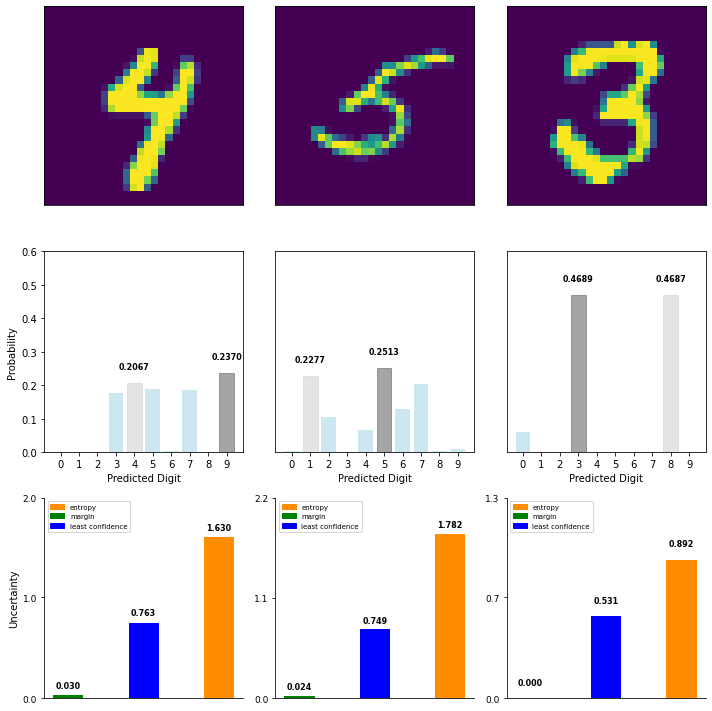

In [5]:
sampling_dict_class_animate = {
    "Least Confidence": {
        "color_scheme": "blue",
        "sample_label": None,
        "sample": None,
        "query_strat": uncertainty_sampling,
    },
    "Entropy": {
        "color_scheme": "darkorange",
        "sample_label": None,
        "sample": None,
        "query_strat": entropy_sampling,
    },
    "Margin": {
        "color_scheme": "green",
        "sample_label": None,
        "sample": None,
        "query_strat": margin_sampling,
    },
}

# All plots
plot_list = ["imshow", "probability", "uncertanity"]

animate_classification_mnist(
    sampling_dict_class_animate,
    plot_list,
    LogisticRegression(max_iter=1000, random_state=42),
    3,
    3,
    n_queries=5,
    train_size=140,
)